In [2]:
!pip install scikit-network

# SD212: Graph mining
## Lab 7: Graph embedding

In this lab, you will learn to embed the nodes of a graph in a vector space of low dimension.

## Import

In [3]:
from IPython.display import SVG

In [4]:
import numpy as np
from scipy import sparse

In [5]:
# if you get any error, please update scikit-network!
from sknetwork.data import load_netset, karate_club
from sknetwork.clustering import KMeans
from sknetwork.embedding import Spectral, BiSpectral
from sknetwork.linalg import HalkoEig
from sknetwork.ranking import PageRank, BiPageRank, top_k
from sknetwork.visualization import svg_graph, svg_digraph

## Data

We will work on the following graphs (see the [NetSets](https://graphs.telecom-paristech.fr/Home_page.html#netsets-section) collection for details):
* Openflights (graph)
* WikiVitals (digraph)
* Cinema (bigraph)

In [6]:
openflights = load_netset('openflights')
wikivitals = load_netset('wikivitals')
cinema = load_netset('cinema')

Parsing files...
Done.
Parsing files...
Done.
Parsing files...
Done.


## 1. Graphs

## Karate Club


We first consider the spectral embedding of the [karate club graph](https://en.wikipedia.org/wiki/Zachary%27s_karate_club).

In [7]:
graph = karate_club(True)

In [8]:
adjacency = graph.adjacency
position = graph.position
labels_true = graph.labels


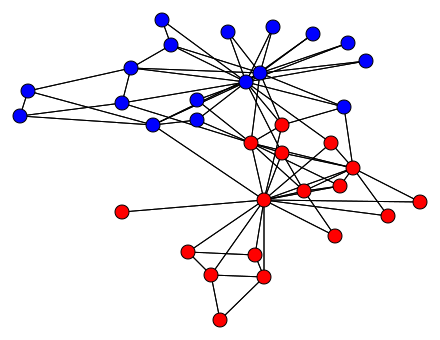

In [9]:
image = svg_graph(adjacency, position, labels=labels_true)
SVG(image)

## To do

* Display the spectrum of the normalized Laplacian (e.g., first 20 eigenvalues). 
* What does the spectrum suggest?
* Display the graph with the embedding in dimension 2.
* Check that the embedding weighted by the degrees is centered.
* How many nodes are misclassified using the sign of the first eigenvector? What are these nodes?

In [10]:
spectral = Spectral(20, normalized=False, regularization=None)

In [11]:
spectral.fit(adjacency)

Spectral(n_components=20, regularization=None, relative_regularization=True, scaling=0.5, normalized=False, solver='auto')

In [12]:
eigenvalues = spectral.eigenvalues_

In [13]:
spectral.eigenvalues_

array([ 8.67727671e-01,  7.12951015e-01,  6.12686767e-01,  3.87769460e-01,
        3.51007053e-01,  2.92791798e-01,  2.60042011e-01,  2.29089383e-01,
        1.77057148e-01,  1.35167055e-01,  9.31839984e-02,  2.81301428e-16,
        4.48621351e-18,  4.01635096e-18,  5.31235771e-33,  2.78312792e-33,
        1.55626596e-34, -1.23591950e-33, -3.96282171e-33, -3.00314971e-18])

In [14]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(spectral.eigenvalues_,'.')
plt.show()

<Figure size 640x480 with 1 Axes>

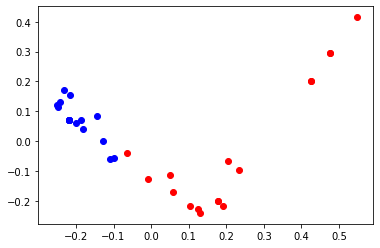

In [15]:
spectral = Spectral(2, normalized=False, regularization=None)
spectral.fit(adjacency)
plt.figure()
plt.scatter(spectral.embedding_[:,0][labels_true==0],spectral.embedding_[:,1][labels_true==0], color='blue')
plt.scatter(spectral.embedding_[:,0][labels_true==1],spectral.embedding_[:,1][labels_true==1], color='red')
plt.show()

In [16]:
# spectral.embedding_*adjacency.sum(axis=1).dot(np.array([1,1]).reshape((1,2)))
np.mean(spectral.embedding_*np.asarray(adjacency.sum(axis=1)),axis=0)

array([3.60495947e-15, 1.24083750e-16])

In [17]:
np.sum((spectral.eigenvectors_[:,0]<0)!=labels_true)

32

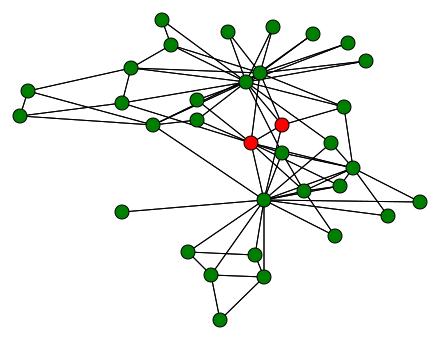

In [18]:
(spectral.eigenvectors_[:,0]<0)!=labels_true
labels = labels_true
labels_true[(spectral.eigenvectors_[:,0]<0)!=labels_true]=2
image = svg_graph(adjacency, position, labels=labels)
SVG(image)

## Openflights


We now consider a larger graph. We use the Laplacian eigenmap in dimension 20. We measure proximity between nodes in terms of [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity). Equivalently, we work on the embedding in the unit sphere, which can be obtained through the parameter ``normalized`` of the class ``Spectral``.

In [19]:
graph = openflights

In [20]:
adjacency = graph.adjacency
position = graph.position
names = graph.names

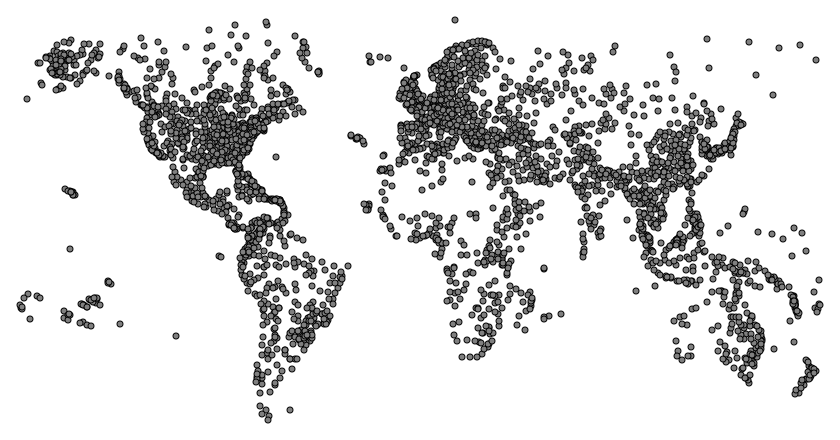

In [21]:
image = svg_graph(adjacency, position, width=800, height=400, node_size=3, display_edges=False)
SVG(image)

## To do

* Display the spectrum of the normalized Laplacian.
* Display the same world map with the scores equal to the cosine similarity to **Beijing** in the embedding space.
* List the 10 closest airports to **Madrid** in terms of cosine similarity in the embedding space.
* Display the same world map with the 10 clusters found by k-means in the embedding space.<br> **Hint:** Use the class ``KMeans`` with the appropriate embedding.

In [22]:
spectral = Spectral(20)

In [23]:
beijing = 1618

In [24]:
madrid = 572

[0.94887173 0.93347697 0.92900809 0.92530143 0.91436071 0.90878655
 0.90139911 0.8846981  0.87772711 0.86924063 0.85331152 0.84750765
 0.83149473 0.8229014  0.79853588 0.79215966 0.74148532 0.69544785
 0.67334026 0.61653657]


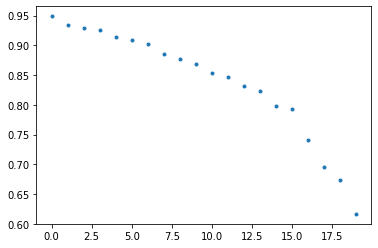

In [25]:
spectral.fit(adjacency)
print(spectral.eigenvalues_)
plt.figure()
plt.plot(spectral.eigenvalues_,'.')
plt.show()

In [26]:
np.sum(spectral.embedding_**2,axis=1)

array([1., 1., 1., ..., 1., 1., 1.])

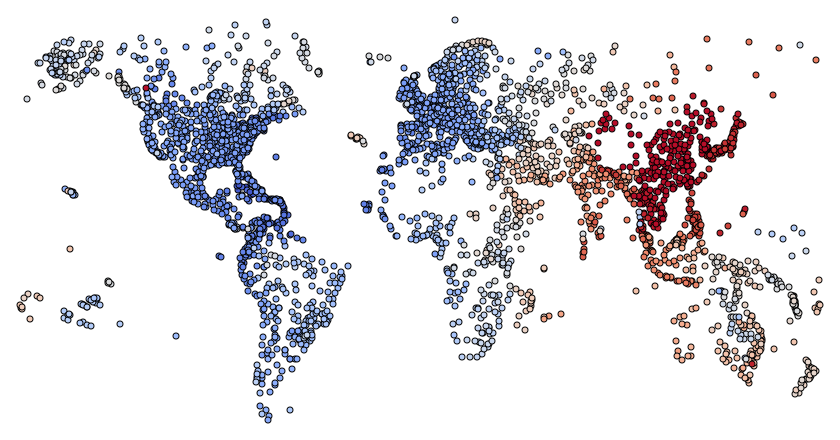

In [27]:
score = spectral.embedding_.dot(spectral.embedding_[beijing])
image = svg_graph(adjacency, position, width=800, height=400, node_size=3, display_edges=False, scores=score)
SVG(image)

In [30]:
names[top_k(spectral.embedding_.dot(spectral.embedding_[madrid]),11)]

array(['Adolfo Suárez Madrid–Barajas Airport', 'Pamplona Airport',
       'Logroño-Agoncillo Airport', 'A Coruña Airport',
       'San Sebastian Airport', 'Badajoz Airport',
       'Tenerife Norte Airport', 'Francisco de Sá Carneiro Airport',
       'Manchester Airport', 'London Gatwick Airport',
       'La Gomera Airport'], dtype='<U65')

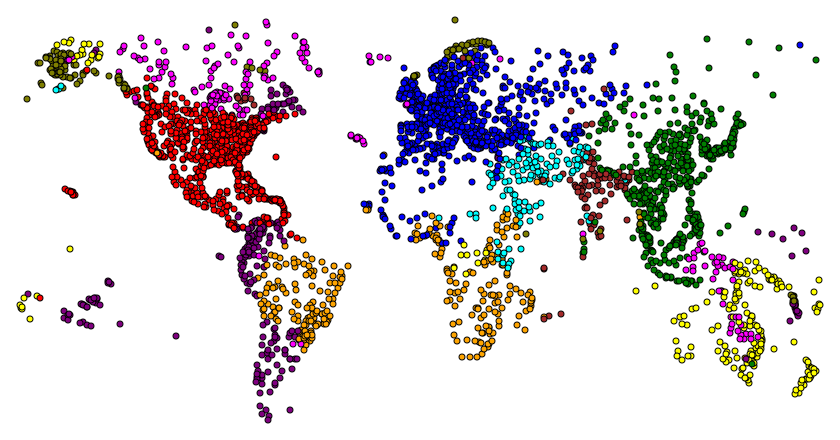

In [31]:
kmeans = KMeans(10, spectral)
labels = kmeans.fit_transform(adjacency)
image = svg_graph(adjacency, position, width=800, height=400, node_size=3, display_edges=False, labels=labels)
SVG(image)

## 2. Digraphs

## Wikipedia Vitals

We now consider a large directed graph. We use the class ``BiSpectral`` (i.e., the directed graph is viewed as a bipartite graph).

In [32]:
graph = wikivitals

In [33]:
adjacency = graph.adjacency
names = graph.names
labels = graph.labels_hierarchy
names_labels = graph.names_labels_hierarchy
names

array(['The arts', 'Art', 'Architecture', ..., 'Baby transport',
       'Pipeline transport', 'Tractor'], dtype='<U62')

## To do

* Check that the average cosine similarity between nodes in some set $S$ is given by the square norm of the barycenter of $S$.
* Give the average cosine similarity between nodes in the **Mammals** category.
* Compare with the expected cosine similarity between two nodes sampled uniformly at random.
* Give the average cosine similarity between nodes in some category of your choice.

In [34]:
spectral = BiSpectral(20, solver=HalkoEig(random_state=42))

In [35]:
mammal = 274

In [36]:
names_labels[mammal]

'Biology and health sciences.Organisms.Animals.Mammals'

In [37]:
spectral.fit(adjacency)

BiSpectral(n_components=20, regularization=0.01, relative_regularization=True, scaling=0.5, normalized=True, solver=HalkoEig(which='LM', n_oversamples=10, n_iter='auto', power_iteration_normalizer='auto', one_pass=False))

In [38]:
np.sum(spectral.embedding_row_**2,axis=1)[np.sum(spectral.embedding_row_**2,axis=1)!=1][0]

1.0000000000000002

In [39]:
# cos_sim = np.zeros((adjacency.shape[0],adjacency.shape[0]))
# for i in range(adjacency.shape[0]):
#   # cos_sim[i] = spectral.embedding_row_.dot(spectral.embedding_row_[i])/np.sqrt(np.sum((spectral.embedding_row_**2),axis=1))/np.sqrt(np.sum(spectral.embedding_row_[i]**2))
#   cos_sim[i] = spectral.embedding_row_.dot(spectral.embedding_row_[i])
# count=0
# tot=0
# for i in range(adjacency.shape[0]-1):
#   tot = tot + np.sum(cos_sim[i][i+1:])
#   count = count + adjacency.shape[0]-i-1
# tot/count, cos_sim.mean()

In [40]:
spectral.embedding_row_.dot(spectral.embedding_row_.T).mean(), np.sum(np.mean(spectral.embedding_row_,axis=0)**2)

(0.013934169906176195, 0.013934169906176054)

In [41]:
embeddings = spectral.embedding_row_[np.where(labels==mammal)[0]]
np.mean(embeddings.dot(embeddings.T)), np.sum(np.mean(embeddings,axis=0)**2)

(0.9039119401085832, 0.9039119401085831)

## 3. Bigraphs

## Cinema

Finally, we consider the co-embedding of a large bipartite graph. We use the Laplacian eigenmap in dimension 20.

In [42]:
graph = cinema

In [43]:
biadjacency = graph.biadjacency
movies = graph.names_row
actors = graph.names_col

## To do

* What is the cosine similarity between **Marion Cotillard** and **The Godfather**  in the embedding space?
* What is the cosine similarity between **The Godfather** and **The Godfather 2** in the embedding space?

In [44]:
bispectral = BiSpectral(20, regularization=0.5, solver=HalkoEig(random_state=42))

In [45]:
cotillard = 3814

In [46]:
actors[cotillard]

'Marion Cotillard'

In [47]:
godfather = 69768
godfather2 = 69770

In [48]:
movies[godfather]

'The Godfather'

In [49]:
movies[godfather2]

'The Godfather Part II'

In [50]:
bispectral.fit(biadjacency)
bispectral.embedding_col_[cotillard].dot(bispectral.embedding_row_[godfather])

0.3081340908026042

In [51]:
bispectral.embedding_col_[cotillard].dot(bispectral.embedding_row_[godfather2])

0.39380866734023284

In [54]:
graph = karate_club(True)
adjacency = graph.adjacency
position = graph.position
labels_true = graph.labels
spectral = Spectral(1, normalized=False, regularization=None)
spectral.fit(adjacency)
np.argwhere((spectral.embedding_<0).ravel()!=labels_true)

array([[2],
       [8]], dtype=int64)

In [56]:
graph = openflights
adjacency = graph.adjacency
position = graph.position
names = graph.names
spectral = Spectral(20)
madrid = 572
spectral.fit(adjacency)
#names[top_k(spectral.embedding_.dot(spectral.embedding_[Paris Charles de Gaulle]),2)][-1]

Spectral(n_components=20, regularization=0.01, relative_regularization=True, scaling=0.5, normalized=True, solver='auto')

In [57]:
graph = wikivitals
adjacency = graph.adjacency
names = graph.names
labels = graph.labels_hierarchy
names_labels = graph.names_labels_hierarchy
spectral = BiSpectral(20, solver=HalkoEig(random_state=42))
north_europe = 500
print(names_labels[north_europe])
spectral.fit(adjacency)
embeddings = spectral.embedding_row_[np.where(labels==north_europe)[0]]
np.mean(embeddings.dot(embeddings.T)), np.sum(np.mean(embeddings,axis=0)**2)

Geography.Cities.Europe.Northern Europe


(0.9445978259933248, 0.944597825993325)